In [ ]:
!pip install scikit-survival

In [7]:
#All the imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import sklearn as sk

from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.model_selection import train_test_split


#-----------Other-----------
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

#IO for the files
from google.colab import files
import io

#Clear output
from IPython.display import clear_output

In [ ]:
#Reading csv from upload
uploaded = files.upload()

In [9]:
#All the column names
column_names = ['ID', 'Laser Type', 'Eye', 'Age', 'Type', 'Treated Group', 'Treated Status', 'Treated Time', 'Untreated Group', 'Untreated Status', 'Untreated Time']
raw_ds = pd.read_csv('drdata.csv', na_values="NaN")
raw_ds.columns = column_names

In [23]:
dataset = raw_ds.copy()
dataset2 = raw_ds.copy()

In [24]:
dataset = dataset.drop(columns=['ID','Treated Group', 'Treated Status', 'Treated Time', 'Laser Type'])
dataset['Untreated Status'] = (dataset['Untreated Status'] == 1).astype(bool)

dataset2 = dataset2.drop(columns=['ID','Untreated Group', 'Untreated Status', 'Untreated Time'])
dataset2['Treated Status'] = (dataset2['Treated Status'] == 1).astype(bool)

In [ ]:
dataset2

In [27]:
X = dataset.iloc[:,:-2]
Y = dataset.iloc[:,-2:]
Y = Y.to_records(index=False)

X2 = dataset2.iloc[:,:-2]
Y2 = dataset2.iloc[:,-2:]
Y2 = Y2.to_records(index=False)

In [28]:
# One Hot Encodings
non_dummy_cols = ['Age'] 
dummy_cols = list(set(X.columns) - set(non_dummy_cols))
X = pd.get_dummies(X, columns=dummy_cols)

dummy_cols2 = list(set(X2.columns) - set(non_dummy_cols))
X2 = pd.get_dummies(X2, columns=dummy_cols2)

In [ ]:
X2

In [30]:
random_state = 20

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=random_state)

random_state = 20

X2_train, X2_test, Y2_train, Y2_test = train_test_split(
    X2, Y2, test_size=0.2, random_state=random_state)

In [ ]:
coxnetUT = CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
coxnetUT.fit(X_train, Y_train)

coxnetTR = CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
coxnetTR.fit(X2_train, Y2_train)

In [ ]:
from joblib import dump, load
dump(coxnetUT, 'coxnetUT.joblib') 
dump(coxnetTR, 'coxnetTR.joblib') 

In [35]:
surv_funcs = {}
for alpha in coxnetUT.alphas_[:5]:
    surv_funcs[alpha] = coxnetUT.predict_survival_function(
        X_train.iloc[150:151], alpha=alpha)
    
surv_funcs2 = {}
for alpha in coxnetTR.alphas_[:5]:
    surv_funcs2[alpha] = coxnetTR.predict_survival_function(
        X2_train.iloc[150:151], alpha=alpha)

No handles with labels found to put in legend.


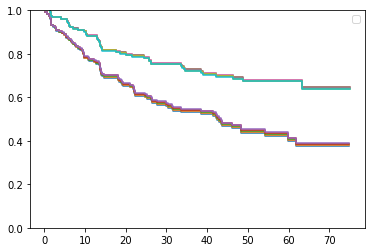

In [38]:
for alpha, surv_alpha in surv_funcs.items():
    for fn in surv_alpha:
        plt.step(fn.x, fn(fn.x), where="post")

for alpha, surv_alpha in surv_funcs2.items():
    for fn in surv_alpha:
        plt.step(fn.x, fn(fn.x), where="post")

plt.ylim(0, 1)
plt.legend()
plt.show()